## Instructions

### Inputs    
   - **stock_name:** The stock you want to predict, eg.'^NSEI'.
   - **frequency:** Use/predict based on monthly or daily data. (Frequency = 'Monthly' or 'Daily')
   - **method:** How do you want deal with original data. (Default is no change, method = 'log' to log the price)
   - **start_date:** The start date of your dataset. (Default = '2016-01-01', until today)
   - **pred_start_date:** The start date of validation predictions. (Default = '2020-01-01')
   - **arimaOrder:** ARIMA model parameter.(Default = (0,1,0))
    
### Outputs
   - **Prediction table**
   - **4 Validation prediction graphs + 1 prediction graph**


In [1]:
#!pip install yfinance
#!pip install pmdarima
import yfinance as yf
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
import math

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [2]:
# Integrated prediction function

def pricePredict(stock_name, frequency, method = None, start_date = '2016-01-01', pred_start_date = '2021-01-01', total_predict_month = 12, predict_times = 4, arimaOrder = (0,1,0)):

    import yfinance as yf
    stock_info = yf.Ticker(stock_name)
    if frequency == 'Monthly':
        Data = stock_info.history(start = start_date, interval = "1mo").dropna()
    elif frequency == 'Daily':
        Data = stock_info.history(start = start_date)        
        Data = Data.fillna(0)
    else: print('Frequency must be Monthly or Daily')

    pred_start_date = datetime.strptime(pred_start_date,'%Y-%m-%d')
    predict_month = int(total_predict_month/predict_times)
    
    if method == None:
        Data = Data['Close']
    elif method == 'log':
        Data = np.log(Data['Close'])
    else: print('the method is not valid')

    # Initiate Table
    table = pd.DataFrame(np.zeros((predict_times,4)))
    table.columns = ['Predicted price', 'Actual price','Predicted Return',"Actual Return"]
    table.index = list('Q'+str(name) for name in np.arange(1,predict_times+1))
    
    for i in np.arange(1,predict_times+1):
        
        # 1.split data
        # select certain data needed
        ye = pred_start_date.year
        mo = (pred_start_date.month + int((predict_month)*i))
        if mo > 12:
            ye = ye + mo//12
            mo = mo%12
        end_date = Data[(Data.index.year == ye) & (Data.index.month == mo)].index[0]
#         end_date = pred_start_date + relativedelta(months = int((predict_month)*i))
        
        if end_date in Data.index:
            RealData = Data[:Data.index.get_loc(end_date)]
        else:
            RealData = Data
            
        # split data into train and training set
        if frequency == 'Monthly':
            train_data, test_data = RealData[:int(len(RealData))-predict_month], RealData[int(len(RealData))-predict_month:]
        elif frequency == 'Daily':
            
            year = pred_start_date.year
            month = pred_start_date.month + predict_month*(i-1)
            if month > 12:
                year = year + month//12
                month = month%12
            end_date_test = RealData[(RealData.index.year == year) & (RealData.index.month == month)].index[0]
            train_data, test_data = RealData[:RealData.index.get_loc(end_date_test)], RealData[RealData.index.get_loc(end_date_test):]
        else: print('Frequency must be Monthly or Daily')
        
#         # plot
#         plt.subplot(2,2,i)
#         plt.grid(True)
#         plt.xlabel('Dates')
#         plt.ylabel('Closing Prices')
#         plt.plot(RealData, 'green', label='Train data')
#         plt.plot(test_data, 'blue', label='Test data')
#         plt.legend()

        # 2.Build Model
        model = ARIMA(train_data, order = arimaOrder) 
        fitted = model.fit(disp=-1)
#         print(fitted.summary())
        #Forecast
        fc, se, conf = fitted.forecast(len(test_data), alpha=0.05)  # 95% conf

        # 3.Prediction & Plot
        # Code of fixing the gap on the plot
        fixFc = np.insert(fc,0,train_data[-1])
        fixIndex = train_data.index[[-1]].append(test_data.index)
        fixLowCon = np.insert(conf[:, 0],0,train_data[-1])
        fixUpCon = np.insert(conf[:, 1],0,train_data[-1])
        fixRealData = pd.concat([train_data[[-1]],test_data])
        # Make as pandas series
        fc_series = pd.Series(fixFc, index=fixIndex)
        lower_series = pd.Series(fixLowCon, index=fixIndex)
        upper_series = pd.Series(fixUpCon, index=fixIndex)
        # Plot
        plt.figure(figsize=(10,5), dpi=100)
        plt.plot(train_data, label='training data')
        plt.plot(fixRealData, color = 'blue', label='Actual Stock Price')
        plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
        plt.fill_between(lower_series.index, lower_series, upper_series, 
                         color='k', alpha=.10)
        plt.title(stock_name + ' Stock Price Prediction for Q' + str(i), fontsize=15)
        plt.xlabel('Time', fontsize=10)
        plt.ylabel(stock_name + ' Stock Price', fontsize=10)
        plt.legend(loc='upper left', fontsize=8)
        
        # 4.Input data to table
        table.iloc[i-1,0] = math.exp(fixFc[-1]) # Predict price
        table.iloc[i-1,1] = math.exp(fixRealData[-1]) # Actual price
        table.iloc[i-1,2] = "{:.2%}".format((math.exp(fixFc[-1])-math.exp(fixFc[0]))/math.exp(fixFc[0])) # Predict return
        table.iloc[i-1,3] = "{:.2%}".format((math.exp(fixRealData[-1])-math.exp(fixRealData[0]))/math.exp(fixRealData[0])) # Actual return
    
    # Prediction
    #Modeling
    model = ARIMA(Data, order = arimaOrder)  
    fitted = model.fit(disp=-1)  
#     print(fitted.summary())
    #Forecast
    if frequency == 'Daily':
        predictions = ((Data.index[-1] + relativedelta(months = int(predict_month))) - Data.index[-1]).days
    elif frequency == 'Monthly':
        predictions = predict_month
    else: print('Frequency must be Monthly or Daily')
    fc, se, conf = fitted.forecast(predictions, alpha=0.05)  # 95% conf
    # fixing code
    fixFc = np.insert(fc,0,Data[-1])
    fixIndex = []
    for i in np.arange(1,predictions+2):
        if frequency == 'Daily':
            fixIndex.append((Data.index[-1] + relativedelta(days = int(i-1))).strftime('%Y-%m-%d'))
        elif frequency == 'Monthly': 
            fixIndex.append((Data.index[-1] + relativedelta(months = int(i-1))).strftime('%Y-%m-%d'))
        else: print('Frequency must be Monthly or Daily')
    fixIndex = pd.to_datetime(fixIndex)
    fixLowCon = np.insert(conf[:, 0],0,Data[-1])
    fixUpCon = np.insert(conf[:, 1],0,Data[-1])
    # Make as pandas series
    fc_series = pd.Series(fixFc, index=fixIndex)
    lower_series = pd.Series(fixLowCon, index=fixIndex)
    upper_series = pd.Series(fixUpCon, index=fixIndex)
    # Plot
    plt.figure(figsize=(10,5), dpi=100)
    plt.plot(Data, label='training data')
    plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
    plt.fill_between(lower_series.index, lower_series, upper_series, 
                     color='k', alpha=.10)
    plt.title(stock_name + ' Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel(stock_name + ' Stock Price')
    plt.legend(loc='upper left', fontsize=8)
    # write in table
    pred = pd.DataFrame({'Predicted price': math.exp(fixFc[-1]), 
                         'Actual price': '-', 
                         'Predicted Return': "{:.2%}".format((math.exp(fixFc[-1])-math.exp(fixFc[0]))/math.exp(fixFc[0])), 
                         'Actual Return': '-'}, index = ['2022Q1(Prediction)'])  # Predict price
    table = table.append(pred)
    
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(table)

In [ ]:
'''
#Test for stationarity

def test_stationarity(timeseries,average=windows):
    #Determing rolling statistics
    rolmean = timeseries.rolling(average).mean()
    rolstd = timeseries.rolling(average).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(stock_price['Close'])

#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(stock_price['Close'], model='multiplicative', freq = predictmonths)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(stock_price['Close'])
moving_avg = df_log.rolling(windows).mean()
std_dev = df_log.rolling(windows).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()
'''

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

,Predicted price,Actual price,Predicted Return,Actual Return
Q1,14394.171209,14690.700195,2.95%,5.07%
Q2,15138.646271,15721.5,3.05%,7.02%
Q3,16245.476083,17618.150391,3.33%,12.06%
Q4,18271.346761,17354.050781,3.71%,-1.50%
2022Q1(Prediction),17991.484561,-,4.76%,-


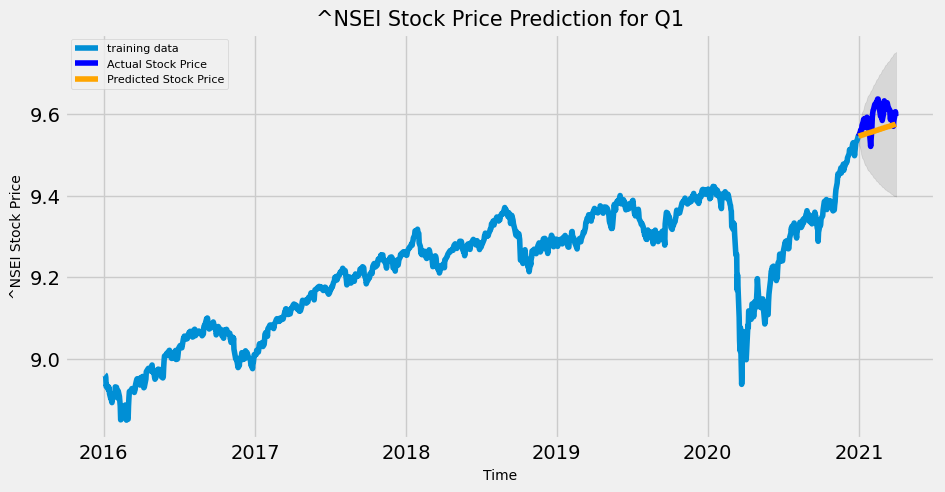

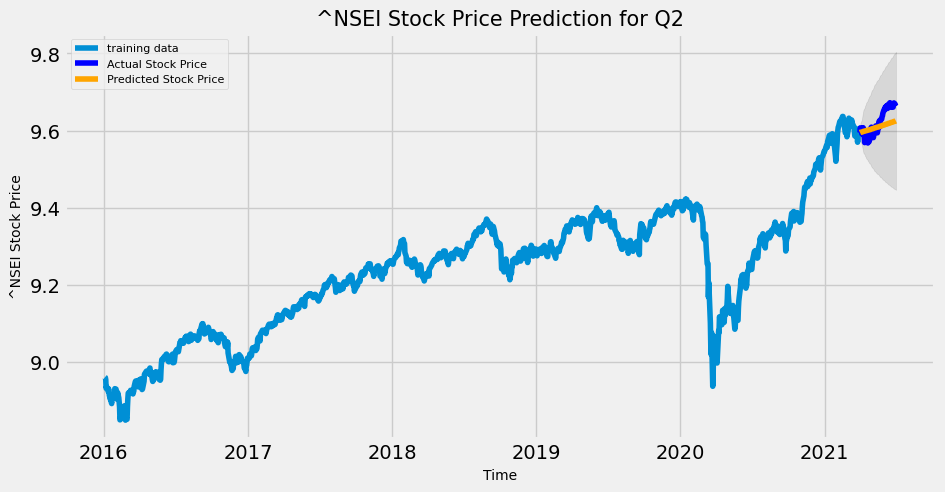

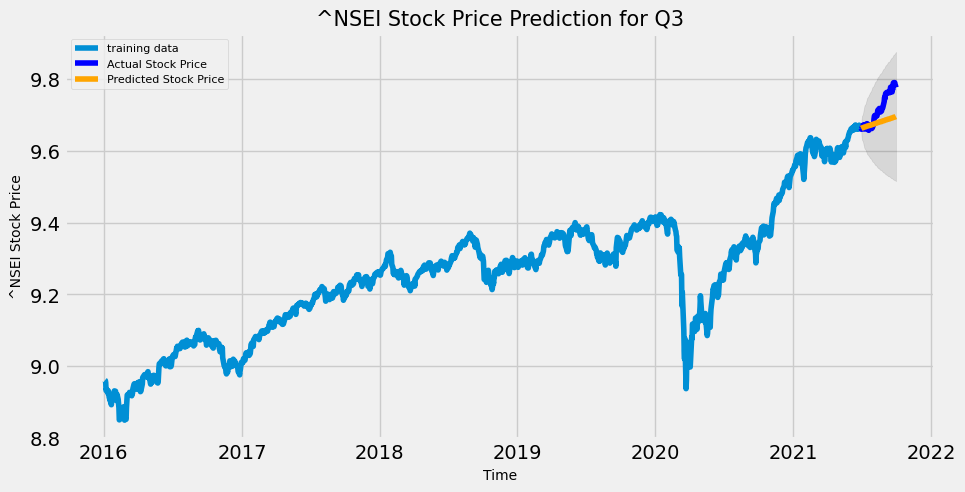

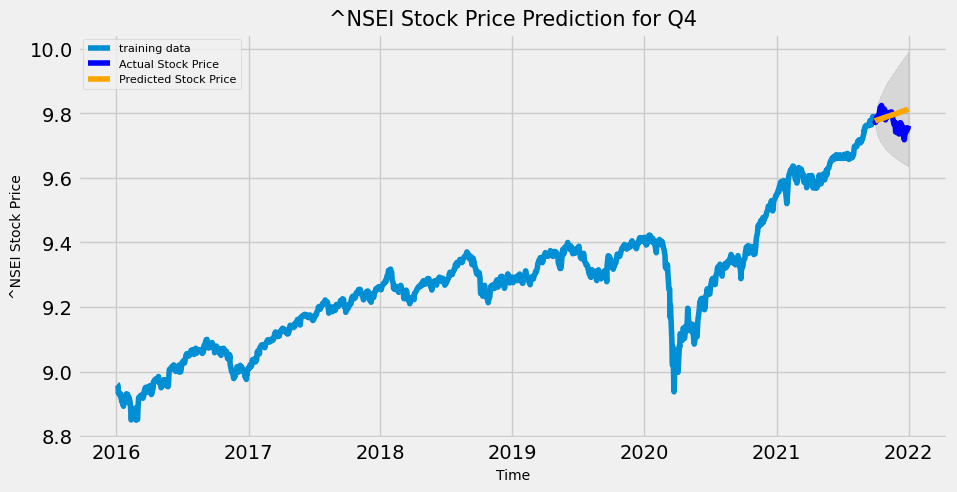

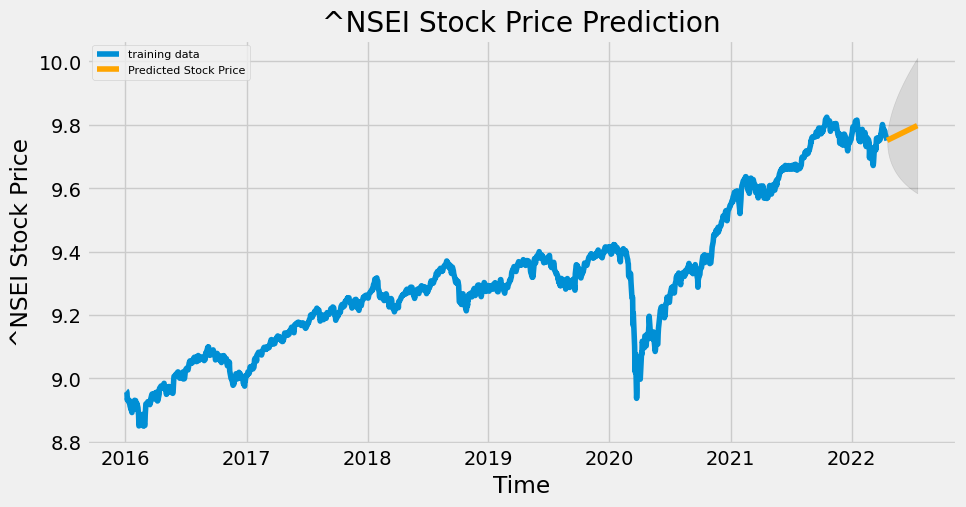

In [3]:
pricePredict(stock_name="^NSEI", frequency='Daily', method = 'log')